<a href="https://colab.research.google.com/github/EgorSolovei/Decision-trees-in-nuclear-physics/blob/main/%D0%9D%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BE%D0%B1%D0%B7%D0%BE%D1%80_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

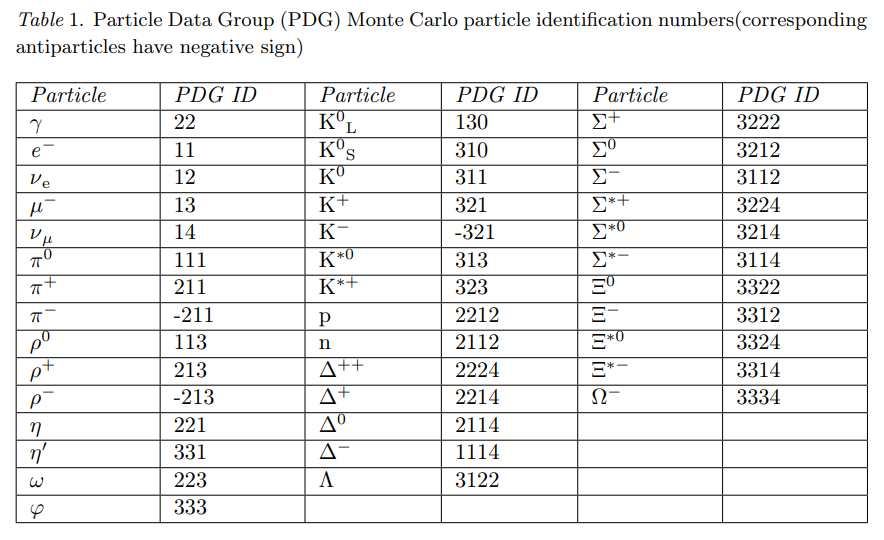

#Поставновка задачи
- Задача классификации. Мы хотим относить прицельный параметр к одному из классов, где классы - это какой-то отрезок. Получается для каждого столкновения мы имеем набор данных, который относится только к одному классу. Можно каждый раз перед началом данных каждого столкновения смотреть прицельный параметр, сразу относить его к назначенному классу и создать колонку, в которой и будет содержаться класс прицельного параметра. Именно эта колонка и будет нашим target'ом. Разбиения возьму точно такие же, как взял Кирилл, хотя ,по честному, нужно посмотреть распределение прицельных параметров, чтобы было равенство классов, которое (вроде бы) важно для алгоритмов: \\
(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\
Данные нужно готовить так, как будто они пришли на датчик. А датчик реагирует только на заряженные частицы и область, в которую прилетела частица



- Задача регрессии. По не пока ничего не могу рассудить

In [1]:
import pandas as pd
import numpy as np

При загрузке файлов могут возникнуть проблемы. Нужно в первую строку каждого файла добавить название колонок, а потом переименовать их.

In [2]:
data_1_df = pd.read_csv('Data_1.csv', sep=';', index_col=False)

data_1_df.head()

,particle_charge,lepton_number,strangeness,baryon_number,type_of_particles,impulse_x,impulse_y,impulse_z,impulse_z_lab,param_5,mass
0,1,1062,7.226,-6.821,2.384,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0.000,0.000,22.000,0.038747,0.098051,0.239720,2.91390,-0.239720,0.0
2,0,1,0.000,0.000,22.000,0.290970,-0.050649,-0.132510,1.09150,0.132510,0.0
3,0,1,0.000,0.000,22.000,-0.110860,0.841320,0.211970,6.28620,-0.211970,0.0
4,0,1,0.000,0.000,22.000,0.096298,0.001396,-0.098164,0.21856,0.098164,0.0


In [3]:
data_1_df.impulse_x[0]

nan

In [4]:
data_1_df.isna().sum()

particle_charge         0
lepton_number           0
strangeness             0
baryon_number           0
type_of_particles       0
impulse_x            1298
impulse_y            1298
impulse_z            1298
impulse_z_lab        1298
param_5              1298
mass                 1299
dtype: int64

In [5]:
data_1_df.shape

(961561, 11)

In [6]:
# убрали пока не нужные коллонки
data_1_df = data_1_df.drop(columns=['baryon_number', 'impulse_z_lab', 'param_5'])

# заменим все NaN, предполагая, что такого значения в массе нет, так как она должна быть положительна
data_1_df = data_1_df.fillna(-1)
data_1_df.head()

,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass
0,1,1062,7.226,2.384,-1.000000,-1.000000,-1.000000,-1.0
1,0,1,0.000,22.000,0.038747,0.098051,0.239720,0.0
2,0,1,0.000,22.000,0.290970,-0.050649,-0.132510,0.0
3,0,1,0.000,22.000,-0.110860,0.841320,0.211970,0.0
4,0,1,0.000,22.000,0.096298,0.001396,-0.098164,0.0


In [7]:
# проверка сколько у нас событий (то есть мест, где раньше стояли NaN)
data_1_df.query('mass == -1').agg({'mass': 'count'}) 

mass    1299
dtype: int64

(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\
$[a_i, b_i)$ - отрезок $i$ - ого класса. Где левая граница включена, а правая - нет.
Мы знаем количество частиц в событии (столкновении), но мы какую-то часть отфильтровываем (по зарядям и импульсам). Поэтому мы вначале для всех частиц сделаем классификацию по прицельному параметру, а потом отфильтруем ненужные. \\
Можно вначале сделать фильтрацию данных, а потом классификацию, но для этого нужно придумывать другой, более сложный алгоритм

In [8]:
a_1 = 0
b_1 = 7
a_2 = 7
b_2 = 9.8
a_3 = 9.8
b_3 = 12
a_4 = 12
b_4 = 16.347

# созданим заранее колонку с классом прицельного параметра, заполненную нулями
data_1_df['class_of_impact_param'] = 0

# работает долго. Наверняка можно написать лучше
# классифицирует прицельный параметр
def class_impact_param(data):
    for i in range(data.shape[0]):
        if data.mass[i] == -1:
            impact_param = data.strangeness[i]
            quantity_of_particles = int(data.lepton_number[i]) # количество элементов в событии
            # если нижнюю границу делать i + 1 + quantity_of_particles, то 0 меньше, чем 2000, 
            # если нижнюю границу делать i + quantity_of_particles, то 0 больше, чем 2000
            if a_1 <= impact_param < b_1:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 1
            if a_2 <= impact_param < b_2:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 2
            if a_3 <= impact_param < b_3:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 3
            if a_4 <= impact_param <= b_4: # b_4 - граница включительна, так как она последняя
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 4

            # # для задачи регрессии
            # data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = impact_param
        

In [9]:
class_impact_param(data_1_df)

<ipython-input-8-cb8f80b64338>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 2
<ipython-input-8-cb8f80b64338>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 4
<ipython-input-8-cb8f80b64338>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_of_part

In [10]:
data_1_df.head()

,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param
0,1,1062,7.226,2.384,-1.000000,-1.000000,-1.000000,-1.0,0
1,0,1,0.000,22.000,0.038747,0.098051,0.239720,0.0,2
2,0,1,0.000,22.000,0.290970,-0.050649,-0.132510,0.0,2
3,0,1,0.000,22.000,-0.110860,0.841320,0.211970,0.0,2
4,0,1,0.000,22.000,0.096298,0.001396,-0.098164,0.0,2


In [11]:
# видно что есть диcбаланс классов
data_1_df.groupby(['class_of_impact_param']).agg({'class_of_impact_param': 'count'}, as_index=False)

,class_of_impact_param
class_of_impact_param,
0,1298
1,521683
2,302132
3,110658
4,25790


In [12]:
data_1_df.query('mass == -1').agg({'mass': 'count'}) # сходится с изначальным показанием

mass    1299
dtype: int64

In [13]:
# больше нам эти колонки не нужны, так как мы уже сделали классификацию по прицельному параметру
data_1_df = data_1_df.drop(columns=['lepton_number', 'strangeness'])
data_1_df = data_1_df.query('class_of_impact_param != 0')

In [14]:
data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param
1,0,22.0,0.038747,0.098051,0.239720,0.0,2
2,0,22.0,0.290970,-0.050649,-0.132510,0.0,2
3,0,22.0,-0.110860,0.841320,0.211970,0.0,2
4,0,22.0,0.096298,0.001396,-0.098164,0.0,2
5,0,22.0,0.041370,0.257660,-0.085403,0.0,2


In [15]:
data_1_df.shape

(960263, 7)

# Фильтрация
1) только заряженные частицы != 0 \\
2) посчитаем длину вектора импульса \\
3) На первом этапе можно не учитывать тип частицы. \\
4) Данные после столкновения \\
5) Попадает ли частица на детектор - первый этап - очистить данные по различным параметрам \\
6) Мы хотим предсказывать прицельный параметр - второй этап - задача регрессии

In [16]:
data_1_df = data_1_df.query("particle_charge != 0") # убрали все нулевые заряды

|$\vec{P}| = \sqrt{p_{x}^2 + p_{y}^2+  p_{z}^2}$

In [17]:
# посчитали суммарный импульс для каждой частицы
def total_impulse(df): 
    total = np.power(df.impulse_x, 2) + np.power(df.impulse_y, 2) + np.power(df.impulse_z, 2)
    return np.sqrt(total)


data_1_df['modul_sum_impulse'] = total_impulse(data_1_df)

<ipython-input-17-d603c81c05b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_df['modul_sum_impulse'] = total_impulse(data_1_df)


In [18]:
data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse
19,1,211.0,0.228800,-0.220680,-0.856760,0.13957,2,0.913831
21,1,211.0,-0.055182,0.188130,-0.458750,0.13957,2,0.498888
25,1,211.0,0.096027,0.055379,0.066079,0.13957,2,0.129052
34,1,211.0,-0.057866,0.056417,-0.195960,0.13957,2,0.211971
36,1,2212.0,-0.418190,-0.067341,9.104700,0.93828,2,9.114548


##Зарегестрировавший датчик

Далее введём параметры нашего эксперимента: \\
- Внешний радиус кольца детектора - R
- радиус выреза для 1-ого, 2-ого и 3-его кольца будем считатать одинаковым - $r_{cut}$ \\
- расстояние до 1-ого, 2-ого и 3-его кольца соответственно - $dist_1$, $dist_2$, $dist_3$. \\



Введём сферические координаты: \\
$p_x = |\vec P| cos(ϕ) sin(θ)$ \\
$p_y = |\vec P| sin(ϕ) sin(θ)$ \\
$p_z = |\vec P| cos(ϴ)$ \\
где: $\phi \in [0; 2π], θ ∈ [0; π]$ \\


Сделаем фильтр, который будет проверять долетит ли частица хотя бы на какой нибудь из датчиков. \\
Условие отбора, что хотя бы какая-нибудь из частиц прилетит на датчик: \\
$α_0 <= θ <= β_0$, где: \\
$θ = arccos(\frac{p_z}{|\vec P|})$ \\
$α_0 = arctg(\frac{r_{cut}}{dist_3})$ \\
$β_0 = arctg(\frac{R}{dist_1})$ 


In [19]:
R = 2 # внешний радиус датчика
r_cut = 0.3 # внутренный радиус датчика
dist = [1, 3, 5] # расстояние до соответствующего датчика

alpha_0 = np.arctan(r_cut / dist[2])
beta_0 = np.arctan(R / dist[0])

def to_sensor(data):
    arccos = np.arccos(data.impulse_z / data.modul_sum_impulse)
    # положительное положение датчиков
    result_plus = arccos.between(alpha_0, beta_0, inclusive="neither")
    # отрицательное положение датчиков
    result_minus = arccos.between(np.pi - beta_0, np.pi - alpha_0, inclusive="neither")
    return result_plus | result_minus

data_1_df['to_any_sensor'] = to_sensor(data_1_df)
data_1_df = data_1_df.query("to_any_sensor == True") # убираем те частицы, которые не долетаю ни до одного датчика
data_1_df.shape # примерно 570к событий

<ipython-input-19-42dfdcd2bc3c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_df['to_any_sensor'] = to_sensor(data_1_df)


(364786, 9)

In [20]:
# уберём колонки, которые уже не пригодятся
# здесь каждая частица долетит до какого-нибудь датчика. Поэтому to_any_sensor уже не нужна
data_1_df = data_1_df.drop(columns=["particle_charge", "type_of_particles", "to_any_sensor"]) 
data_1_df.head()

,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse
19,0.228800,-0.220680,-0.856760,0.13957,2,0.913831
21,-0.055182,0.188130,-0.458750,0.13957,2,0.498888
25,0.096027,0.055379,0.066079,0.13957,2,0.129052
34,-0.057866,0.056417,-0.195960,0.13957,2,0.211971
44,0.132900,-0.010070,2.130200,0.13957,2,2.134365


Теперь нужно реализовать: \\
1) Через какие датчики пролетает каждая частица \\
2) Разбиваем кольцо на сектора и пишем условия попадания в каждый сектор (см. тетрадь) \\
3) Оцениваем время пролёта частицы. Если частица пролетает через несколько датчиков, то нужно считать время пролёта до каждого датчика? 

Для каждого датчика составим коллонку. Если частица пролетела через датчик в положительном положении => 1, если пролетела через симметричный датчик в отрицательном положении => -1, если не пролетела через датчик => 0

In [21]:
alpha_i = [np.arctan(r_cut / dist_i) for dist_i in dist] # минимальные углы для i датчика
beta_i = [np.arctan(R / dist_i) for dist_i in dist] # максимальный угол для i датчика

# создадим коллонку с акркосинусом угла тета
data_1_df["arccos_theta"] = np.arccos(data_1_df.impulse_z / data_1_df.modul_sum_impulse)



# создаём коллонку для каждого датчика и делаем проверку по углам. 
for j in range(3):
    name_column = "sensor_" + str(j + 1) 
    data_1_df[name_column] = 0
    
    # этой функции передаём арккосинус угла и направление датчика
    def between_corner(arccos_series, direct):
        if direct == 1:
            return arccos_series.between(alpha_i[j], beta_i[j])
        elif direct == -1:
            return arccos_series.between(np.pi - beta_i[j], np.pi - alpha_i[j])

    data_1_df.loc[between_corner(data_1_df.arccos_theta, 1), name_column] = 1
    data_1_df.loc[between_corner(data_1_df.arccos_theta, -1), name_column] = -1

data_1_df.head()

,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3
19,0.228800,-0.220680,-0.856760,0.13957,2,0.913831,2.786309,-1,-1,-1
21,-0.055182,0.188130,-0.458750,0.13957,2,0.498888,2.737716,-1,-1,0
25,0.096027,0.055379,0.066079,0.13957,2,0.129052,1.033246,1,0,0
34,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,2.750430,-1,-1,0
44,0.132900,-0.010070,2.130200,0.13957,2,2.134365,0.062486,0,0,1


In [22]:
data_1_df.shape

(364786, 10)

##Разбиение на сектора

Введём 3 дополнительный радиуса - радиусы выреза на датчике. \\
Обязательное условие: $r_{cut} < r_1 < r_2 < r_3 < R$. В таком случае получится 4 кольца разбиения на датчике. \\
Также нужно ввести количество угол, который будет разделять сектора - $\frac{\pi}{4}$. \\
В таком случае получится 32 области разбиения датчика. Нумерацию областей предлагаю взять "улиткой" (см. фото ниже) \\
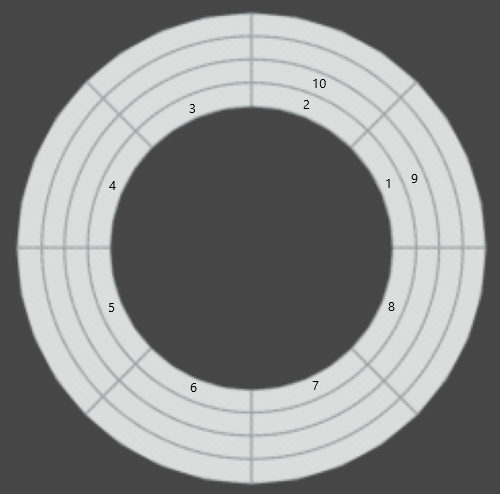

In [23]:
all_r = [r_cut, 0.7, 1.2, 1.6, R] # разбиние на кольца датчика
dist = [1, 3, 5] # расстояние до соответствующего датчика

"""
Определем номер кольца попадания частицы для каждого датчика
Внешний цикл создаёт коллонку для каждой пары датчика, в которой лежат нули.
Внутренний цикл проверяет в какое кольцо на датчике прилетает частица [1, 2, 3, 4] - 4 кольца
Функция во внутреннем цикле работает с отбором по углам
Работает так, как и задумывалось, потому что если частица попала на датчик, то есть номер кольца 
попадания, в случае, если частица не попала на датчик, то как и ожидалось, там 0 
"""
for i in range(3):
    name_column = "number_of_ring_" + str(i + 1)
    data_1_df[name_column] = 0

    for j in range(4):
        alpha_ring = [np.arctan(r / dist[i]) for r in all_r]

        def between_corner(arccos_series, direct): # нужно подумать над углами в between
            if direct == 1:
                return arccos_series.between(alpha_ring[j], alpha_ring[j + 1])
            elif direct == -1:
                return arccos_series.between(np.pi - alpha_ring[j + 1], np.pi - alpha_ring[j])

        data_1_df.loc[between_corner(data_1_df.arccos_theta, 1), name_column] = j + 1
        data_1_df.loc[between_corner(data_1_df.arccos_theta, -1), name_column] = j + 1
    
data_1_df.head()

,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3,number_of_ring_1,number_of_ring_2,number_of_ring_3
19,0.228800,-0.220680,-0.856760,0.13957,2,0.913831,2.786309,-1,-1,-1,1,2,4
21,-0.055182,0.188130,-0.458750,0.13957,2,0.498888,2.737716,-1,-1,0,1,3,0
25,0.096027,0.055379,0.066079,0.13957,2,0.129052,1.033246,1,0,0,4,0,0
34,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,2.750430,-1,-1,0,1,3,0
44,0.132900,-0.010070,2.130200,0.13957,2,2.134365,0.062486,0,0,1,0,0,1


In [24]:
# цикл подобен коду выше, только теперь это делается для части окружности
data_1_df["arctg_phi"] = np.arctan(data_1_df.impulse_y / data_1_df.impulse_x)

for i in range(3):
    name_column = "number_of_piece_" + str(i + 1)
    column_sensor = "sensor_" + str(i + 1)
    data_1_df[name_column] = 0

    def between_angle(left_border, rigth_border):
        result = data_1_df.arctg_phi.between(left_border, rigth_border)
        return result

    """
    Ща будет колхоз. Надо бы как-то переписать это
    Условия по которым идёт отбор: 
    1) Частица должна прилететь на какой-то датчик: data_1_df[column_sensor] != 0
    2) Отбор по знаку impulse_x, так как это определяет нужную половину датчика (правую или левую)
    3) И проверка на какой сектор прилетает частица: between_angle
    """
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x > 0) & (between_angle(-np.pi / 2, -np.pi / 4)), name_column] = 7
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x > 0) & (between_angle(-np.pi / 4, 0)), name_column] = 8
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x > 0) & (between_angle(0, np.pi / 4)), name_column] = 1
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x > 0) & (between_angle(np.pi / 4, np.pi / 2)), name_column] = 2

    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x < 0) & (between_angle(-np.pi / 2, -np.pi / 4)), name_column] = 3
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x < 0) & (between_angle(-np.pi / 4, 0)), name_column] = 4
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x < 0) & (between_angle(0, np.pi / 4)), name_column] = 5
    data_1_df.loc[(data_1_df[column_sensor] != 0) & (data_1_df.impulse_x < 0) & (between_angle(np.pi / 4, np.pi / 2)), name_column] = 6
 
data_1_df.head()

,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3,number_of_ring_1,number_of_ring_2,number_of_ring_3,arctg_phi,number_of_piece_1,number_of_piece_2,number_of_piece_3
19,0.228800,-0.220680,-0.856760,0.13957,2,0.913831,2.786309,-1,-1,-1,1,2,4,-0.767335,8,8,8
21,-0.055182,0.188130,-0.458750,0.13957,2,0.498888,2.737716,-1,-1,0,1,3,0,-1.285481,3,3,0
25,0.096027,0.055379,0.066079,0.13957,2,0.129052,1.033246,1,0,0,4,0,0,0.523113,1,0,0
34,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,2.750430,-1,-1,0,1,3,0,-0.772720,4,4,0
44,0.132900,-0.010070,2.130200,0.13957,2,2.134365,0.062486,0,0,1,0,0,1,-0.075627,0,0,8


In [25]:
# алгоритм определения сектора по кольцу попадания и куску по фи
data_1_df["sector_1"] = (data_1_df.number_of_ring_1 - 1) + data_1_df.number_of_piece_1
data_1_df["sector_2"] = (data_1_df.number_of_ring_2 - 1) + data_1_df.number_of_piece_2
data_1_df["sector_3"] = (data_1_df.number_of_ring_3 - 1) + data_1_df.number_of_piece_3

# алгоритм работает неправильно в случае number_of_ring_i == 0, поэтому так...
data_1_df.sector_1 = data_1_df.sector_1.replace(-1, 0)
data_1_df.sector_2 = data_1_df.sector_2.replace(-1, 0)
data_1_df.sector_3 = data_1_df.sector_3.replace(-1, 0)

# уберём все вспомогательные колонки
data_1_df = data_1_df.drop(columns=['number_of_ring_1', 'number_of_ring_2','number_of_ring_2', 
                                    'number_of_piece_1', 'number_of_piece_2', 'number_of_piece_3',
                                    'arctg_phi', 'arccos_theta'])

# перестави колонки в приятном порядке
data_1_df = data_1_df[['class_of_impact_param', 'impulse_x', 'impulse_y', 'impulse_z', 
                       'modul_sum_impulse', 'mass', 'sensor_1', 'sector_1', 
                       'sensor_2', 'sector_2', 'sensor_3', 'sector_3']]

data_1_df.head()

,class_of_impact_param,impulse_x,impulse_y,impulse_z,modul_sum_impulse,mass,sensor_1,sector_1,sensor_2,sector_2,sensor_3,sector_3
19,2,0.228800,-0.220680,-0.856760,0.913831,0.13957,-1,8,-1,9,-1,11
21,2,-0.055182,0.188130,-0.458750,0.498888,0.13957,-1,3,-1,5,0,0
25,2,0.096027,0.055379,0.066079,0.129052,0.13957,1,4,0,0,0,0
34,2,-0.057866,0.056417,-0.195960,0.211971,0.13957,-1,4,-1,6,0,0
44,2,0.132900,-0.010070,2.130200,2.134365,0.13957,0,0,0,0,1,8


In [26]:
data_1_df.shape

(364786, 12)

Надо бы подумать о том, как написать тест на правильность всех преобразований и что данные действительно отражают то, что я хотел сделать.

##Оценка времени пролёта




$u_z = \frac{p_z}{\sqrt{m_0 ^ 2 + |\vec P| ^ 2}}$ \\
имеем такую систему координат, в которой скорость света c = 1. \\
$t = \frac{S_z}{u_z}$ - время пролёта частицы до датчика. Для каждого датчика считаем время пролёта. 


In [30]:
data_1_df["velocity"] = data_1_df.impulse_z / np.sqrt(data_1_df.mass ** 2 + data_1_df.modul_sum_impulse ** 2)


"""
нужно обрабатывать случаи, когда частица не прилетает на датчик
умножим расстояние на индикатор прилёта частицы - 1, -1 или 0.
в случае, если частица НЕ прилетела на датчик, то и время пролёта будет 0
возьмём модуль, так как для времен не имеет значение, в каком направлении летит частица
"""
data_1_df["time_1"] = abs((dist[0] *  data_1_df.sensor_1) / data_1_df.velocity)
data_1_df["time_2"] = abs((dist[1] * data_1_df.sensor_2) / data_1_df.velocity)
data_1_df["time_3"] = abs((dist[2] * data_1_df.sensor_3) / data_1_df.velocity)

data_1_df.head()

,class_of_impact_param,impulse_x,impulse_y,impulse_z,modul_sum_impulse,mass,sensor_1,sector_1,sensor_2,sector_2,sensor_3,sector_3,velocity,time_1,time_2,time_3
19,2,0.228800,-0.220680,-0.856760,0.913831,0.13957,-1,8,-1,9,-1,11,-0.926800,1.078981,3.236943,5.394905
21,2,-0.055182,0.188130,-0.458750,0.498888,0.13957,-1,3,-1,5,0,0,-0.885543,1.129251,3.387752,0.000000
25,2,0.096027,0.055379,0.066079,0.129052,0.13957,1,4,0,0,0,0,0.347619,2.876709,0.000000,0.000000
34,2,-0.057866,0.056417,-0.195960,0.211971,0.13957,-1,4,-1,6,0,0,-0.772122,1.295132,3.885397,0.000000
44,2,0.132900,-0.010070,2.130200,2.134365,0.13957,0,0,0,0,1,8,0.995921,0.000000,0.000000,5.020477


# Итоговый файл


In [31]:
data_1_df = data_1_df.drop(columns=["velocity", "impulse_x", "impulse_y", "impulse_z", 
                                    "modul_sum_impulse", "mass"])
data_1_df = data_1_df[["sensor_1", "sector_1", "time_1", 
                       "sensor_2", "sector_2", "time_2",
                       "sensor_3", "sector_3", "time_3", "class_of_impact_param"]]
data_1_df.head()

,sensor_1,sector_1,time_1,sensor_2,sector_2,time_2,sensor_3,sector_3,time_3,class_of_impact_param
19,-1,8,1.078981,-1,9,3.236943,-1,11,5.394905,2
21,-1,3,1.129251,-1,5,3.387752,0,0,0.000000,2
25,1,4,2.876709,0,0,0.000000,0,0,0.000000,2
34,-1,4,1.295132,-1,6,3.885397,0,0,0.000000,2
44,0,0,0.000000,0,0,0.000000,1,8,5.020477,2


Итоги: имеем один файл хороших, обработанных данных, на которых можно обучать модель для классификации. Теперь прогоним по этому скрипту остальные данные и сохраним готовые данные для обучения. \\
P.S Если уже с первого файла будет довольно много событий для обучения, то зачем нам ещё какие-то данные?